## Challenge

Network of parcel lockers. These parcel lockers are used by users to ship items.

The standard shipment flow for our parcel lockers is as follows:

1. Seller of a pre-loved item drops off their parcel at a locker;
2. Driver picks up the parcel from the origin locker & brings it to a warehouse;
3. Parcels are sorted in the warehouse;
4. Driver picks up the parcel from the warehouse & drops it off at the destination locker;
5. Buyer of a pre-loved item picks up the parcel from the destination locker.

Every day, we must decide which lockers to visit. This decision involves a **trade-off** between
conflicting business objectives. Visiting more lockers **increases delivery speed, but it also
increases delivery costs.**

In [1]:
!python --version

Python 3.11.4


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import seaborn as sns

sns.set_style("whitegrid")

## Lockers data

In [3]:
lockers_df = pd.read_csv("....csv")

In [4]:
lockers_df.shape

(200, 3)

In [5]:
lockers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   locker_id        200 non-null    int64
 1   available_slots  200 non-null    int64
 2   total_slots      200 non-null    int64
dtypes: int64(3)
memory usage: 4.8 KB


In [6]:
lockers_df.head()

,locker_id,available_slots,total_slots
0,1,14,50
1,2,20,50
2,3,24,50
3,4,15,50
4,5,22,50


### Constraints lockers:
- Availability should be greater than 0

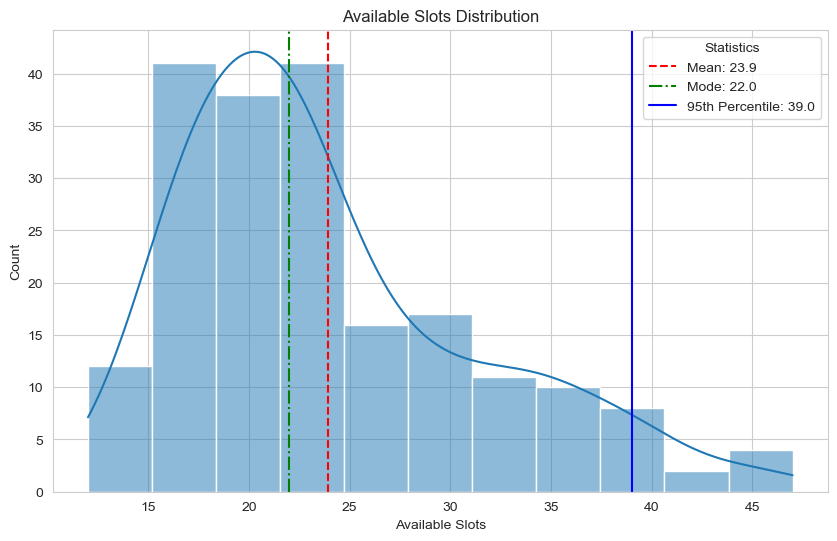

In [7]:
# Plot Available Slots Distribution
plt.figure(figsize=(10, 6))
sns.histplot(lockers_df['available_slots'], kde=True)

mean_line = plt.axvline(lockers_df['available_slots'].mean(), color='r', linestyle='--')
mode_line = plt.axvline(lockers_df['available_slots'].mode()[0], color='g', linestyle='-.')
percentile_line = plt.axvline(lockers_df['available_slots'].quantile(0.95), color='b', linestyle='-')

legend_labels = [mlines.Line2D([], [], color='r', linestyle='--', label=f"Mean: {lockers_df['available_slots'].mean():.1f}"),
                 mlines.Line2D([], [], color='g', linestyle='-.', label=f"Mode: {lockers_df['available_slots'].mode()[0]:.1f}"),
                 mlines.Line2D([], [], color='b', linestyle='-', label=f"95th Percentile: {lockers_df['available_slots'].quantile(0.95):.1f}")]

plt.legend(handles=legend_labels, title="Statistics")
plt.xlabel('Available Slots')
plt.title('Available Slots Distribution')
plt.show()

- The mean number of available slots is around 23.9. On average, a locker will have about 24 empty slots at any given time.
- We can infer that 95% of lockers have 39 or fewer available slots - only a few lockers are almost entirely empty.

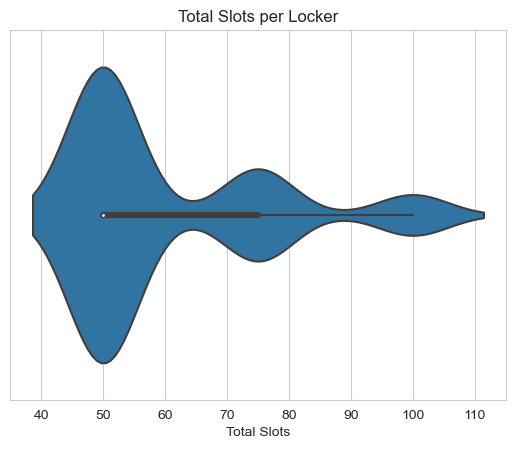

In [8]:
# Plot Total Slots per Locker as a violin plot due to high cardinality in locker_id
sns.violinplot(x=lockers_df['total_slots'])
plt.title('Total Slots per Locker')
plt.xlabel('Total Slots')
plt.show()

In [9]:
# Calculate occupancy ratio for each locker
lockers_df['occupancy_ratio'] = 1 - (lockers_df['available_slots'] / lockers_df['total_slots'])

In [10]:
lockers_df[lockers_df.occupancy_ratio<0.5]

,locker_id,available_slots,total_slots,occupancy_ratio
18,19,26,50,0.480000
31,32,28,50,0.440000
52,53,29,50,0.420000
105,106,38,75,0.493333
109,110,26,50,0.480000
112,113,39,75,0.480000
130,131,26,50,0.480000
132,133,29,50,0.420000
138,139,28,50,0.440000
188,189,26,50,0.480000


In [76]:
lockers_df['occupancy_ratio'].describe()

count    200.000000
mean       0.601883
std        0.064724
min        0.420000
25%        0.560000
50%        0.600000
75%        0.653333
max        0.760000
Name: occupancy_ratio, dtype: float64

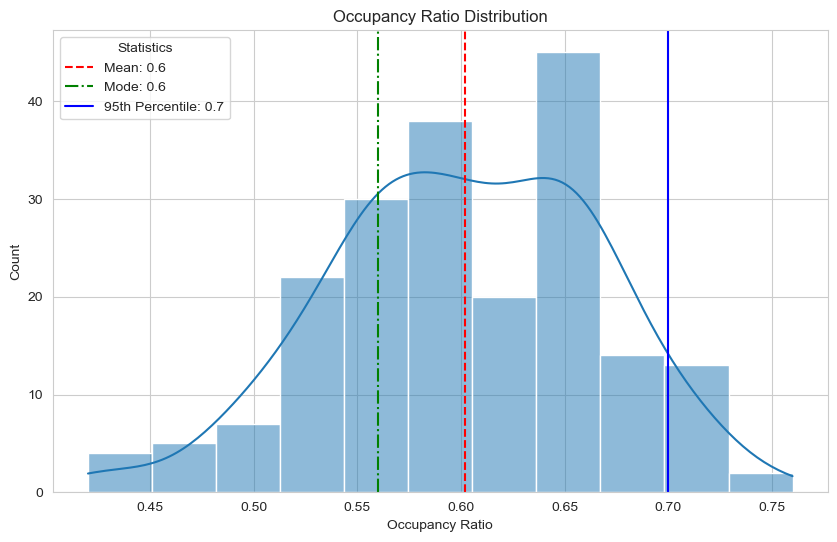

In [11]:
# Plot Occupancy Ratio Distribution

plt.figure(figsize=(10, 6))
sns.histplot(lockers_df['occupancy_ratio'], kde=True)

mean_line = plt.axvline(lockers_df['occupancy_ratio'].mean(), color='r', linestyle='--')
mode_line = plt.axvline(lockers_df['occupancy_ratio'].mode()[0], color='g', linestyle='-.')
percentile_line = plt.axvline(lockers_df['occupancy_ratio'].quantile(0.95), color='b', linestyle='-')

legend_labels = [mlines.Line2D([], [], color='r', linestyle='--', label=f"Mean: {lockers_df['occupancy_ratio'].mean():.1f}"),
                 mlines.Line2D([], [], color='g', linestyle='-.', label=f"Mode: {lockers_df['occupancy_ratio'].mode()[0]:.1f}"),
                 mlines.Line2D([], [], color='b', linestyle='-', label=f"95th Percentile: {lockers_df['occupancy_ratio'].quantile(0.95):.1f}")]

plt.legend(handles=legend_labels, title="Statistics")
plt.xlabel('Occupancy Ratio')
plt.title('Occupancy Ratio Distribution')
plt.show()

- The average and mode being around *60%* and *56%* suggests that there may be room for improving the utilization of the locker space.
- The 95th percentile tells us that some lockers are heavily utilized, and might need to be emptied more often to avoid exceeding capacity (?).

Mean and mode in both distributions - **well-balanced system** - most lockers are neither too empty nor too full, which is a positive indicator of system efficiency.

There is good match between locker capacity and demand for space.

One possible improvement is identify why some lockers are **underutilized** or to take measures to relieve those that are **overfilled**.

## Parcels data

In [12]:
parcels_df = pd.read_csv("....csv", index_col =0)

In [13]:
parcels_df.shape

(5352, 5)

In [14]:
parcels_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5352 entries, 60730603 to 20518917
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   from_locker_id              5352 non-null   int64 
 1   to_locker_id                5352 non-null   int64 
 2   location                    5352 non-null   object
 3   status                      5352 non-null   object
 4   days_since_seller_drop_off  5352 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 250.9+ KB


In [15]:
parcels_df.head()

,from_locker_id,to_locker_id,location,status,days_since_seller_drop_off
tracking_code,,,,,
60730603,1,14,warehouse,in_delivery,3
21033612,1,14,warehouse,in_delivery,4
91420892,1,16,locker,in_delivery,0
31720295,1,34,locker,in_delivery,2
79296744,1,42,warehouse,in_delivery,1


### Constraints parcels:
- `days_since_seller_drop_off` should be less than 5

In [16]:
parcels_df.from_locker_id.nunique()

200

In [17]:
parcels_df.to_locker_id.nunique()

200

In [18]:
parcels_df[parcels_df.days_since_seller_drop_off>5].shape[0] / parcels_df.shape[0]

0.01046337817638266

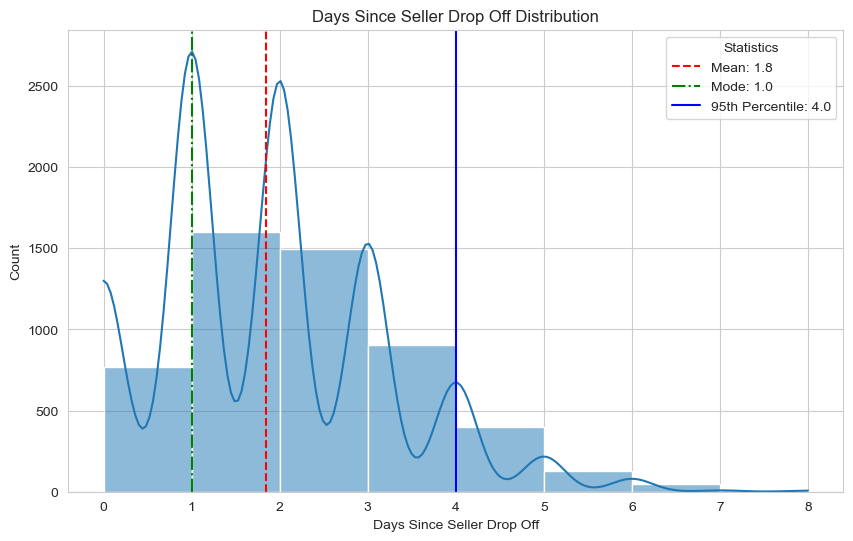

In [19]:
# Plot Days Since Seller Drop Off Distribution

plt.figure(figsize=(10, 6))
sns.histplot(parcels_df['days_since_seller_drop_off'], kde=True, bins=8)

mean_line = plt.axvline(parcels_df['days_since_seller_drop_off'].mean(), color='r', linestyle='--')
mode_line = plt.axvline(parcels_df['days_since_seller_drop_off'].mode()[0], color='g', linestyle='-.')
percentile_line = plt.axvline(parcels_df['days_since_seller_drop_off'].quantile(0.95), color='b', linestyle='-')

legend_labels = [mlines.Line2D([], [], color='r', linestyle='--', label=f"Mean: {parcels_df['days_since_seller_drop_off'].mean():.1f}"),
                 mlines.Line2D([], [], color='g', linestyle='-.', label=f"Mode: {parcels_df['days_since_seller_drop_off'].mode()[0]:.1f}"),
                 mlines.Line2D([], [], color='b', linestyle='-', label=f"95th Percentile: {parcels_df['days_since_seller_drop_off'].quantile(0.95):.1f}")]

plt.legend(handles=legend_labels, title="Statistics")
plt.xlabel('Days Since Seller Drop Off')
plt.title('Days Since Seller Drop Off Distribution')
plt.show()

- On average, parcels stay in lockers for less than 2 days before being picked up - positive sign for achieving the SLA of 5 days.
- Only a small percentage (5%) of parcels are at risk of breaching the SLA.

In [20]:
len(parcels_df[(parcels_df.days_since_seller_drop_off>5)].to_locker_id.unique())

49

In [21]:
parcels_df[(parcels_df.days_since_seller_drop_off>5) & 
           (parcels_df.location == "warehouse")].to_locker_id.unique()

array([152, 177, 114,  93,  38, 184, 150,  18,  80, 137, 151,   6, 115,
       102, 111, 185,  84,  96, 198,   7,  83,  88, 138,  25, 192,  62,
        35,  31, 127,  44,  46,   1, 199, 160, 103, 194,  16, 155, 141,
        26,  95, 123,  23, 175, 101, 124])

In [22]:
parcels_df[(parcels_df.days_since_seller_drop_off>5) & 
           (parcels_df.location == "locker")].from_locker_id.unique()

array([34, 60, 79, 89])

In [23]:
parcels_df.status.unique()

array(['in_delivery'], dtype=object)

In [24]:
parcels_df.location.value_counts(normalize=True)

locker       0.66293
warehouse    0.33707
Name: location, dtype: float64

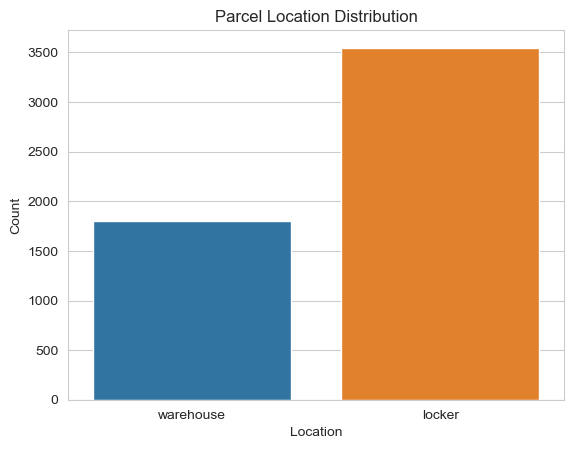

In [25]:
sns.countplot(x='location', data=parcels_df)
plt.title('Parcel Location Distribution')
plt.xlabel('Location')
plt.ylabel('Count')
plt.show()

- Lockers are being used efficiently as storage units - nearing their capacity limits ?
- With only *33.7%* of parcels in the warehouse - warehouse has a good amount of free space for sorting and temporary storage, or it could indicate an efficient flow of parcels through the warehouse.
- Increasing locker visits by drivers rather than expanding warehouse storage, depending on various other cost factors ?
  

### Merge Locker/ Parcel data

In [26]:
# Average days since seller drop-off for each locker
avg_days = parcels_df.groupby('from_locker_id')['days_since_seller_drop_off'].mean().reset_index()
avg_days.columns = ['locker_id', 'avg_days_since_drop_off']

In [27]:
avg_days.head()

,locker_id,avg_days_since_drop_off
0,1,2.172414
1,2,1.904762
2,3,1.571429
3,4,1.823529
4,5,2.000000


In [78]:
avg_days['avg_days_since_drop_off'].describe()

count    200.000000
mean       1.840660
std        0.271291
min        0.952381
25%        1.650000
50%        1.859606
75%        2.000000
max        2.666667
Name: avg_days_since_drop_off, dtype: float64

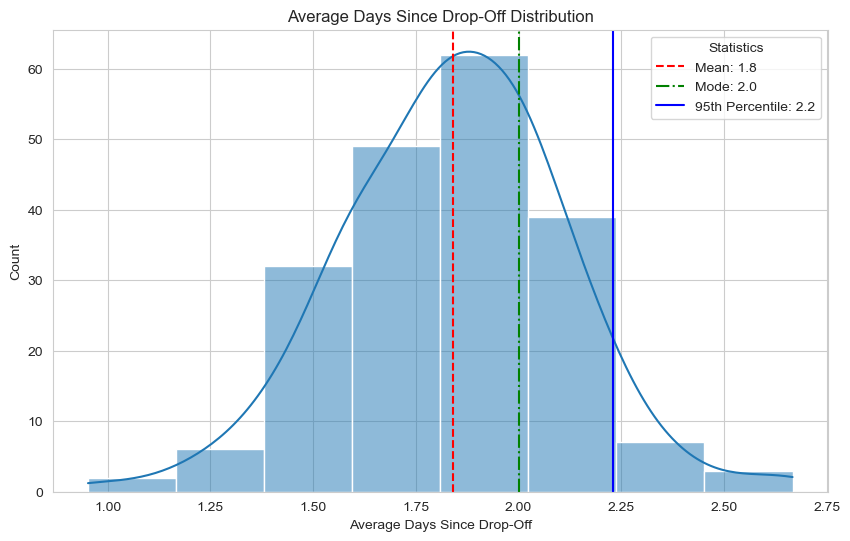

In [77]:
# Plot Average Days Since Drop-Off Distribution

plt.figure(figsize=(10, 6))
sns.histplot(avg_days['avg_days_since_drop_off'], kde=True, bins=8)

mean_line = plt.axvline(avg_days['avg_days_since_drop_off'].mean(), color='r', linestyle='--')
mode_line = plt.axvline(avg_days['avg_days_since_drop_off'].mode()[0], color='g', linestyle='-.')
percentile_line = plt.axvline(avg_days['avg_days_since_drop_off'].quantile(0.95), color='b', linestyle='-')

legend_labels = [mlines.Line2D([], [], color='r', linestyle='--', label=f"Mean: {avg_days['avg_days_since_drop_off'].mean():.1f}"),
                 mlines.Line2D([], [], color='g', linestyle='-.', label=f"Mode: {avg_days['avg_days_since_drop_off'].mode()[0]:.1f}"),
                 mlines.Line2D([], [], color='b', linestyle='-', label=f"95th Percentile: {avg_days['avg_days_since_drop_off'].quantile(0.95):.1f}")]

plt.legend(handles=legend_labels, title="Statistics")
plt.xlabel('Average Days Since Drop-Off')
plt.title('Average Days Since Drop-Off Distribution')
plt.show()

- The mean being around 1.84 suggest that most lockers are experiencing a healthy turnover of parcels. This aligns well with the business goal of maximizing locker usage without overwhelming the system.
- Some lockers with an $AverageDaysSinceDropOff$, close to the maximum might require attention. These could be outliers in terms of SLA violations or inefficient usage, which could potentially disrupt the whole system if not managed.

Given the metrics, there's a strong correlation between locker occupancy and average days since drop-off, suggesting that the system has a good balance between these two metrics.

In [28]:
lockers_df = pd.merge(lockers_df, avg_days, on='locker_id', how='left').fillna(0)

In [29]:
lockers_df.head()

,locker_id,available_slots,total_slots,occupancy_ratio,avg_days_since_drop_off
0,1,14,50,0.72,2.172414
1,2,20,50,0.60,1.904762
2,3,24,50,0.52,1.571429
3,4,15,50,0.70,1.823529
4,5,22,50,0.56,2.000000


Example in-out flow:

In [30]:
parcels_df[(parcels_df['location'] == 'warehouse') & (parcels_df['to_locker_id'] == 1)].from_locker_id.count()

7

**In:** 7 parcels from the warehouse to locker 1

In [31]:
parcels_df[(parcels_df['location'] == 'locker') & (parcels_df['from_locker_id'] == 1)].from_locker_id.count()

18

**Out:** 18 parcels from the locker 1 to the warehouse

In [32]:
7/18

0.3888888888888889

In [33]:
# Calculate In-Out Ratio
in_flow = parcels_df[parcels_df['location'] == 'warehouse'].groupby('to_locker_id').size().reset_index(name='in_flow')
out_flow = parcels_df[parcels_df['location'] == 'locker'].groupby('from_locker_id').size().reset_index(name='out_flow')

In [34]:
flow_df = pd.merge(in_flow, out_flow, left_on='to_locker_id', right_on='from_locker_id', how='outer').fillna(0)
flow_df['in_out_ratio'] = flow_df['in_flow'] / (flow_df['out_flow'])

In [35]:
flow_df.head()

,to_locker_id,in_flow,from_locker_id,out_flow,in_out_ratio
0,1,7,1,18,0.388889
1,2,9,2,14,0.642857
2,3,5,3,18,0.277778
3,4,6,4,22,0.272727
4,5,10,5,13,0.769231


In [79]:
flow_df['in_out_ratio'].describe()

count    200.000000
mean       0.527931
std        0.231463
min        0.083333
25%        0.385561
50%        0.500000
75%        0.617788
max        2.125000
Name: in_out_ratio, dtype: float64

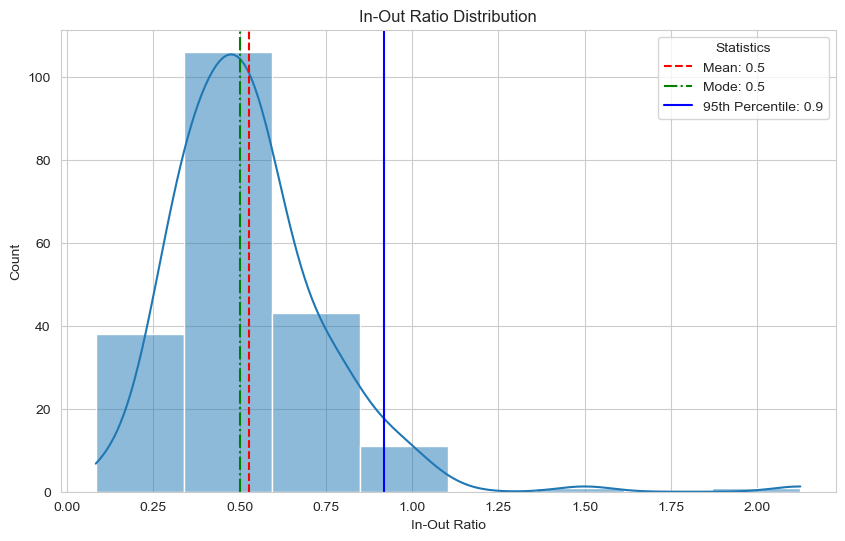

In [36]:
# Plot In-Out Ratio Distribution

plt.figure(figsize=(10, 6))
sns.histplot(flow_df['in_out_ratio'], kde=True, bins=8)

mean_line = plt.axvline(flow_df['in_out_ratio'].mean(), color='r', linestyle='--')
mode_line = plt.axvline(flow_df['in_out_ratio'].mode()[0], color='g', linestyle='-.')
percentile_line = plt.axvline(flow_df['in_out_ratio'].quantile(0.95), color='b', linestyle='-')

legend_labels = [mlines.Line2D([], [], color='r', linestyle='--', label=f"Mean: {flow_df['in_out_ratio'].mean():.1f}"),
                 mlines.Line2D([], [], color='g', linestyle='-.', label=f"Mode: {flow_df['in_out_ratio'].mode()[0]:.1f}"),
                 mlines.Line2D([], [], color='b', linestyle='-', label=f"95th Percentile: {flow_df['in_out_ratio'].quantile(0.95):.1f}")]

plt.legend(handles=legend_labels, title="Statistics")
plt.xlabel('In-Out Ratio')
plt.title('In-Out Ratio Distribution')
plt.show()

- The maximum value of 2.1 indicates that some lockers are experiencing a much higher inflow than outflow, potentially leading to capacity issues. The minimum of 0.08 suggests the opposite problem: lockers that are frequently emptying but not receiving parcels, possibly indicating underutilization.
- High in-out ratios could indicate potential congestion, leading to reduced locker availability for new parcels. Low ratios could signify underutilization, resulting in wasted space and operational inefficiency.

The in-out ratio could be strongly correlated with both the occupancy ratio and average days since drop-off. A balanced in-out ratio likely contributes to a well-utilized locker system (higher occupancy ratio) and a lower risk of SLA violations (lower average days since drop-off).

In [37]:
lockers_df = pd.merge(lockers_df, flow_df[["from_locker_id", "in_flow", "out_flow", "in_out_ratio"]], 
                      left_on='locker_id', right_on='from_locker_id', how='left').fillna(0)

lockers_df = lockers_df.drop(columns = ["from_locker_id"])

In [38]:
lockers_df.head()

,locker_id,available_slots,total_slots,occupancy_ratio,avg_days_since_drop_off,in_flow,out_flow,in_out_ratio
0,1,14,50,0.72,2.172414,7,18,0.388889
1,2,20,50,0.60,1.904762,9,14,0.642857
2,3,24,50,0.52,1.571429,5,18,0.277778
3,4,15,50,0.70,1.823529,6,22,0.272727
4,5,22,50,0.56,2.000000,10,13,0.769231


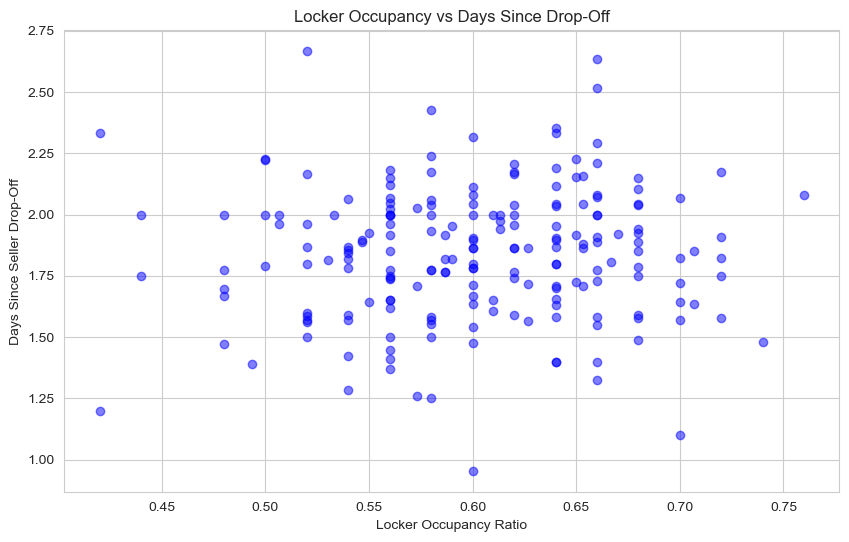

In [39]:
# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(lockers_df['occupancy_ratio'], lockers_df['avg_days_since_drop_off'], c='blue', alpha=0.5)
plt.title('Locker Occupancy vs Days Since Drop-Off')
plt.xlabel('Locker Occupancy Ratio')
plt.ylabel('Days Since Seller Drop-Off')
plt.show()

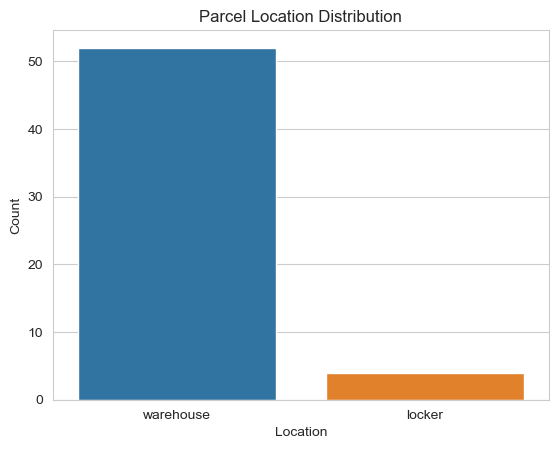

In [123]:
location_stats = parcels_df[parcels_df['days_since_seller_drop_off'] > 5]
sns.countplot(x='location', data=location_stats)
plt.title('Parcel Location Distribution')
plt.xlabel('Location')
plt.ylabel('Count')
plt.show()

In [40]:
# Identify parcels that violate the SLA
over_sla = parcels_df[parcels_df['days_since_seller_drop_off'] > 5].groupby('from_locker_id').size().reset_index()
over_sla.columns = ['locker_id', 'parcels_over_sla']
over_sla = over_sla.sort_values(by='parcels_over_sla', ascending=False)

In [82]:
over_sla.head()

,locker_id,parcels_over_sla
7,20,3
31,133,2
43,181,2
40,169,2
11,30,2


In [83]:
over_sla.shape

(49, 2)

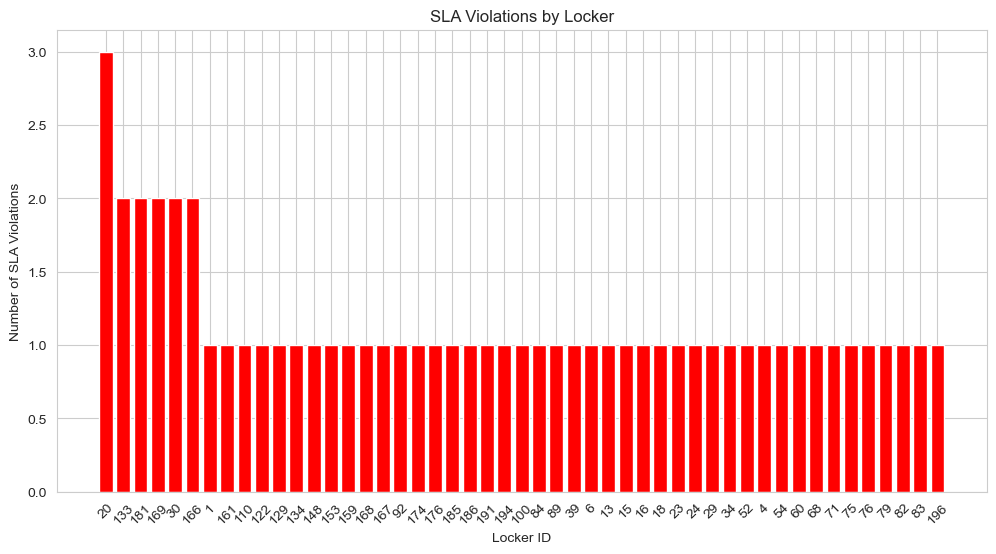

In [80]:
plt.figure(figsize=(12, 6))
plt.bar(over_sla['locker_id'].astype(str), over_sla['parcels_over_sla'], color='red')
plt.xlabel('Locker ID')
plt.ylabel('Number of SLA Violations')
plt.title('SLA Violations by Locker')
plt.xticks(rotation=45)
plt.show()

In [42]:
# Merge Over SLA info
lockers_df = pd.merge(lockers_df, over_sla, on='locker_id', how='left').fillna(0)

In [43]:
lockers_df.head()

,locker_id,available_slots,total_slots,occupancy_ratio,avg_days_since_drop_off,in_flow,out_flow,in_out_ratio,parcels_over_sla
0,1,14,50,0.72,2.172414,7,18,0.388889,1.0
1,2,20,50,0.60,1.904762,9,14,0.642857,0.0
2,3,24,50,0.52,1.571429,5,18,0.277778,0.0
3,4,15,50,0.70,1.823529,6,22,0.272727,1.0
4,5,22,50,0.56,2.000000,10,13,0.769231,0.0


In [84]:
lockers_df['parcels_over_sla'].describe()

count    200.000000
mean       0.280000
std        0.531992
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: parcels_over_sla, dtype: float64

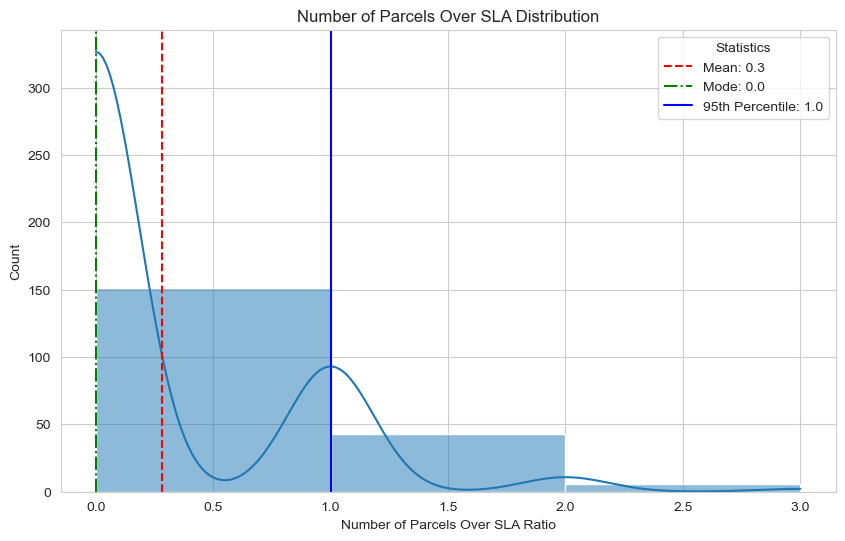

In [86]:
# Plot Number of Parcels Over SLA Distribution

plt.figure(figsize=(10, 6))
sns.histplot(lockers_df['parcels_over_sla'], kde=True, bins=3)

mean_line = plt.axvline(lockers_df['parcels_over_sla'].mean(), color='r', linestyle='--')
mode_line = plt.axvline(lockers_df['parcels_over_sla'].mode()[0], color='g', linestyle='-.')
percentile_line = plt.axvline(lockers_df['parcels_over_sla'].quantile(0.95), color='b', linestyle='-')

legend_labels = [mlines.Line2D([], [], color='r', linestyle='--', label=f"Mean: {lockers_df['parcels_over_sla'].mean():.1f}"),
                 mlines.Line2D([], [], color='g', linestyle='-.', label=f"Mode: {lockers_df['parcels_over_sla'].mode()[0]:.1f}"),
                 mlines.Line2D([], [], color='b', linestyle='-', label=f"95th Percentile: {lockers_df['parcels_over_sla'].quantile(0.95):.1f}")]

plt.legend(handles=legend_labels, title="Statistics")
plt.xlabel('Number of Parcels Over SLA Ratio')
plt.title('Number of Parcels Over SLA Distribution')
plt.show()

- Most lockers generally don't have parcels over the Service Level Agreement (SLA). This is positive from a customer satisfaction perspective.
- The maximum value is 3, which means that even the worst-performing lockers are not egregiously violating SLAs. However, any violation may negatively impact customer experience and should be investigated.
- Having a low average of parcels over SLA minimizes the risk of customer dissatisfaction, refunds, or even loss of clients due to delayed parcels. However, any non-zero value should be a flag for review.

The low number of parcels exceeding SLAs across most lockers suggests that, from this perspective, the system is operating efficiently and effectively. However, even a few SLA violations can be significant in terms of customer satisfaction, and therefore those outliers warrant closer inspection.

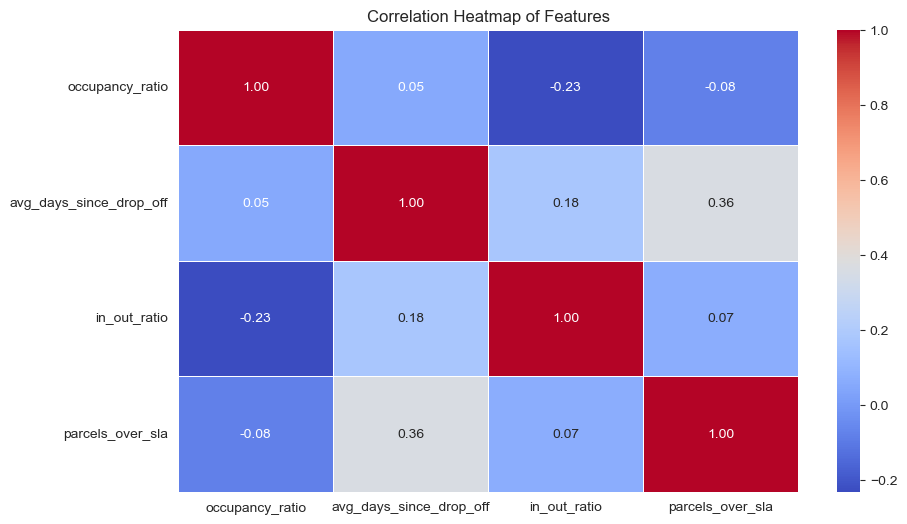

In [44]:
corr_matrix = lockers_df[['occupancy_ratio', 'avg_days_since_drop_off', 
                          'in_out_ratio', 'parcels_over_sla']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

## Section I: Prioritization Framework


### A) Define a set of measures for the framework

#### **Metrics**

1. **Occupancy Ratio of a Locker:** The ratio of used slots to total slots in a locker. **High ratios should be prioritized.** A locker close to being full needs to be emptied to maintain capacity for new parcels.

$$\text{OccupancyRatio}_{i} = 1 - \frac{\text{AvailableSlots}_{i}}{\text{TotalSlots}_{i}}$$


2. **Average Days Since Drop-off:** The average number of days parcels have been waiting in a locker since the seller drop-off. A high average suggests parcels are not being moved quickly enough, risking SLA violation.

$$\text{AvgDaysSinceDropOff}_{i} = \frac{1}{N} \sum_{j=1}^{N} \text{DaysSinceSellerDropOff}_{ij}$$

3. **In-Out Ratio:** This is the ratio of the number of parcels incoming to a locker to the number of parcels outgoing from that locker. A higher value indicates that more parcels are being moved from the warehouse to the locker, which aligns with the goal of reducing warehouse storage requirements (assumption).

$$\text{InOutRatio}_{i} = \frac{\text{InFlow}_{i}}{\text{OutFlow}_{i}}$$

4. **SLA Violation Count:** The number of parcels in a locker that have been waiting for more than 5 days since the seller drop-off, thereby violating the SLA.

$$\text{SLA\_Violation}_{i}$$

#### **Objective function**


Finally, the objective function could look like:

$$\max \sum_{i=1}^{M} \left( a \times \text{OccupancyRatio}_{i} + b \times \text{AvgDaysSinceDropOff}_{i} + c \times \text{InOutRatio}_{i} + P \times \text{SLA\_Violation}_{i} \right)$$

This accomplishes the best of both worlds. At the same time that we want to maximize directly occupancy rate, we also want to maximize the value for AvgDaysSinceDropOff. $a$, $b$ and $c$ are the weights for each metric. $P$ is a penalty term for SLA violations.

#### **Contraints:**

1. **SLA Constraint:** Enforces that the number of days a parcel has been waiting since it was dropped off by the seller should be less than or equal to 5. This ensures that each parcel meets the 5-day Service Level Agreement (SLA) for delivery.

$$\text{DaysSinceSellerDropOff}_{i} \leq 5$$

2. **Driver's Locker Visits:** A driver can visit at most 20 lockers per day.

$$\sum_{i=1}^{M} \text{LockerVar}_{i} \leq 20$$

#### **Full Optimization Problem Statement**

\begin{equation}
    \text{max} \quad \sum_{i=1}^{M} \left( a \times \text{OccupancyRatio}_{i} + b \times \text{AvgDaysSinceDropOff}_{i} + c \times \text{InOutRatio}_{i} + P \times \text{SLA\_Violation}_{i} \right)
\end{equation}

\begin{equation}
    \text{Subject to:}
\end{equation}

\begin{equation}
    \text{DaysSinceSellerDropOff}_{i} \leq 5, \quad \forall i \in \{1, 2, \ldots, M\}
\end{equation}

\begin{equation}
    \sum_{i=1}^{M} \text{LockerVar}_{i} \leq 20
\end{equation}

---

**Occupancy Ratio**
  - **Business Perspective:** A locker that is almost full should be prioritized for emptying, as it has less space for new parcels.
  - **Objective:** Maximized. The higher the occupancy ratio, the more urgent the need for emptying it.
  - $a$: Allows us to control the importance of this metric relative to others.

---

**Average Days Since Drop-Off**
  - **Business Perspective:** Parcels that have been in the locker for an extended period should be moved as they risk violating the Service Level Agreement (SLA).
  - **Objective:** Maximized. However, it's more about flagging those that have high average days, indicating urgency.
  - $b$: Allows us to give importance to lockers that have parcels nearing SLA violation.

---

**In-Out Ratio**
  - **Business Perspective:** A higher in-out ratio is desirable as it indicates that more parcels are being moved from the warehouse to the lockers, thus reducing the parcel count in the warehouse and maximizing locker usage.
  - **Objective:** Maximized. A high value for in-out ratio directly contributes to reducing the warehouse load and improving locker utilization.
  - $c$: Helps control the emphasis we put on this balance between incoming and outgoing parcels.

---

**SLA Violation**
  - **Business Perspective:** Any SLA violation is a serious issue and can damage customer trust and result in penalties.
  - **Objective:** Now maximized. We add a penalty term for each locker that has an SLA violation, indicating the urgency to resolve these cases.
  - Penalty $P$: A value that helps ensure that any locker with an SLA violation gets prioritized for emptying.

---

#### Data Assumptions
- The snapshot is an accurate representation of a typical day.
- Drivers work in 8-hour shifts, and it takes an average of 20 minutes to empty a locker.
- The number of drivers is not known, so we aim to minimize locker visits within the given constraint of 20 lockers per driver per day.
- We want reduce the parcel count in the warehouse and maximizing locker usage.

## Section II: Implementing Framework

### Naive approach

In [45]:
# Prioritization Algorithm

# Step 1: Urgent Lockers
urgent_lockers = lockers_df[lockers_df['parcels_over_sla'] > 0]

In [46]:
urgent_lockers.head()

,locker_id,available_slots,total_slots,occupancy_ratio,avg_days_since_drop_off,in_flow,out_flow,in_out_ratio,parcels_over_sla
0,1,14,50,0.720000,2.172414,7,18,0.388889,1.0
3,4,15,50,0.700000,1.823529,6,22,0.272727,1.0
5,6,32,75,0.573333,1.709677,8,23,0.347826,1.0
12,13,24,50,0.520000,1.800000,4,13,0.307692,1.0
14,15,22,50,0.560000,1.650000,6,14,0.428571,1.0


In [47]:
urgent_lockers.shape

(49, 9)

In [48]:
urgent_lockers.locker_id.unique()

array([  1,   4,   6,  13,  15,  16,  18,  20,  23,  24,  29,  30,  34,
        39,  52,  54,  60,  68,  71,  75,  76,  79,  82,  83,  84,  89,
        92, 100, 110, 122, 129, 133, 134, 148, 153, 159, 161, 166, 167,
       168, 169, 174, 176, 181, 185, 186, 191, 194, 196])

In [49]:
# Step 2: High Occupancy
high_occupancy_lockers = lockers_df[lockers_df['occupancy_ratio'] > 0.7]

In [50]:
high_occupancy_lockers.head()

,locker_id,available_slots,total_slots,occupancy_ratio,avg_days_since_drop_off,in_flow,out_flow,in_out_ratio,parcels_over_sla
0,1,14,50,0.720000,2.172414,7,18,0.388889,1.0
21,22,14,50,0.720000,1.909091,8,16,0.500000,0.0
79,80,21,75,0.720000,1.825000,10,31,0.322581,0.0
85,86,22,75,0.706667,1.852941,10,24,0.416667,0.0
93,94,14,50,0.720000,1.576923,5,22,0.227273,0.0


In [51]:
# Step 3: Aged Parcels
aged_parcels_lockers = lockers_df[lockers_df['avg_days_since_drop_off'] > 3]

In [52]:
# Step 4: All remaining lockers
remaining_lockers = lockers_df

In [53]:
# Combine all steps
prioritized_lockers_from_naive = pd.concat([urgent_lockers, high_occupancy_lockers, 
                                            aged_parcels_lockers, remaining_lockers]).drop_duplicates()

In [54]:
# Assuming one driver can visit 20 lockers in one shift
prioritized_lockers_from_naive = prioritized_lockers_from_naive.head(20)

In [55]:
prioritized_lockers_from_naive.head()

,locker_id,available_slots,total_slots,occupancy_ratio,avg_days_since_drop_off,in_flow,out_flow,in_out_ratio,parcels_over_sla
0,1,14,50,0.720000,2.172414,7,18,0.388889,1.0
3,4,15,50,0.700000,1.823529,6,22,0.272727,1.0
5,6,32,75,0.573333,1.709677,8,23,0.347826,1.0
12,13,24,50,0.520000,1.800000,4,13,0.307692,1.0
14,15,22,50,0.560000,1.650000,6,14,0.428571,1.0


In [56]:
prioritized_lockers_from_naive.locker_id.values.tolist()

[1, 4, 6, 13, 15, 16, 18, 20, 23, 24, 29, 30, 34, 39, 52, 54, 60, 68, 71, 75]

In [57]:
prioritized_lockers_from_naive = prioritized_lockers_from_naive.locker_id.values.tolist()

In [58]:
parcels_df[(parcels_df.from_locker_id.isin(prioritized_lockers_from_naive)) | 
           (parcels_df.to_locker_id.isin(prioritized_lockers_from_naive))].head()

,from_locker_id,to_locker_id,location,status,days_since_seller_drop_off
tracking_code,,,,,
60730603,1,14,warehouse,in_delivery,3
21033612,1,14,warehouse,in_delivery,4
91420892,1,16,locker,in_delivery,0
31720295,1,34,locker,in_delivery,2
79296744,1,42,warehouse,in_delivery,1


In [59]:
parcels_df[(parcels_df.from_locker_id.isin(prioritized_lockers_from_naive)) | 
           (parcels_df.to_locker_id.isin(prioritized_lockers_from_naive))].shape[0] / parcels_df.shape[0] * 100

20.40358744394619

In [60]:
parcels_df[parcels_df.from_locker_id.isin(prioritized_lockers_from_naive)]["days_since_seller_drop_off"].mean()

1.9650582362728786

### Pulp

In [61]:
lockers_df.head()

,locker_id,available_slots,total_slots,occupancy_ratio,avg_days_since_drop_off,in_flow,out_flow,in_out_ratio,parcels_over_sla
0,1,14,50,0.72,2.172414,7,18,0.388889,1.0
1,2,20,50,0.60,1.904762,9,14,0.642857,0.0
2,3,24,50,0.52,1.571429,5,18,0.277778,0.0
3,4,15,50,0.70,1.823529,6,22,0.272727,1.0
4,5,22,50,0.56,2.000000,10,13,0.769231,0.0


In [62]:
from pulp import LpMaximize, LpMinimize, LpProblem, LpVariable, lpSum

In [63]:
# Create the model
model = LpProblem(name="locker-prioritization", sense=LpMaximize)

In [64]:
# Declare variables (binary variables for each locker)
locker_vars = LpVariable.dicts("Locker", lockers_df['locker_id'], 0, 1, 'Binary')

In [65]:
# Penalty term for SLA violations
a, b, c, P = 1, 1, 1, 10

In [66]:
# Objective Function: Maximize (a*occupancy_ratio + b*avg_days_since_drop_off + c*in_out_ratio + P * parcels_over_sla)
# Here a, b, c are weights we can adjust based on how important each metric is
model += lpSum(
    [
        locker_vars[i] * (
            a * lockers_df.loc[lockers_df['locker_id'] == i, 'occupancy_ratio'].values[0] +
            b * lockers_df.loc[lockers_df['locker_id'] == i, 'avg_days_since_drop_off'].values[0] +
            c * lockers_df.loc[lockers_df['locker_id'] == i, 'in_out_ratio'].values[0] + 
            P * lockers_df.loc[lockers_df['locker_id'] == i, 'parcels_over_sla'].values[0]
        )
        for i in lockers_df['locker_id']
    ]
), "Total_Priority"

In [67]:
# Constraint for maximum lockers a driver can visit
max_lockers_per_driver = 20
model += lpSum([locker_vars[i] for i in lockers_df['locker_id']]) <= max_lockers_per_driver, "Max_Lockers_Per_Driver"

In [68]:
# Solve the problem
model.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/lf/anaconda3/envs/snakes/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/cl/8l42ht8d4k70pf3by032y2qc0000gn/T/90bfcf70e846436b8deea82f943a6e63-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/cl/8l42ht8d4k70pf3by032y2qc0000gn/T/90bfcf70e846436b8deea82f943a6e63-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 6 COLUMNS
At line 807 RHS
At line 809 BOUNDS
At line 1010 ENDATA
Problem MODEL has 1 rows, 200 columns and 200 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 339.629 - 0.00 seconds
Cgl0004I processed model has 1 rows, 200 columns (200 integer (200 of which binary)) and 200 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -339.629
Cbc0038I Before mini branch and bound, 200 integers at b

1

In [69]:
# Output the chosen lockers
prioritized_lockers_from_pulp = [locker_id for locker_id in lockers_df['locker_id'] if locker_vars[locker_id].value() == 1]
print(f"Chosen lockers to prioritize: {prioritized_lockers_from_pulp}")

Chosen lockers to prioritize: [1, 20, 29, 30, 39, 75, 83, 92, 100, 122, 133, 134, 153, 161, 166, 169, 176, 181, 185, 186]


In [70]:
prioritized_lockers_from_naive

[1, 4, 6, 13, 15, 16, 18, 20, 23, 24, 29, 30, 34, 39, 52, 54, 60, 68, 71, 75]

### Comparing the 2 approaches

In [71]:
# Extract metrics for the 20 prioritized lockers from each approach
metrics_pulp = lockers_df[lockers_df['locker_id'].isin(prioritized_lockers_from_pulp)]
metrics_naive = lockers_df[lockers_df['locker_id'].isin(prioritized_lockers_from_naive)]

# Calculate the average metrics
avg_metrics_pulp = metrics_pulp[['occupancy_ratio', 'avg_days_since_drop_off', 'in_out_ratio', 'parcels_over_sla']].mean()
avg_metrics_naive = metrics_naive[['occupancy_ratio', 'avg_days_since_drop_off', 'in_out_ratio', 'parcels_over_sla']].mean()

metrics_df = pd.DataFrame({'Pulp Approach': avg_metrics_pulp, 'Naive Approach': avg_metrics_naive})
metrics_df

,Pulp Approach,Naive Approach
occupancy_ratio,0.596333,0.614500
avg_days_since_drop_off,2.201206,1.944652
in_out_ratio,0.683889,0.476419
parcels_over_sla,1.350000,1.150000


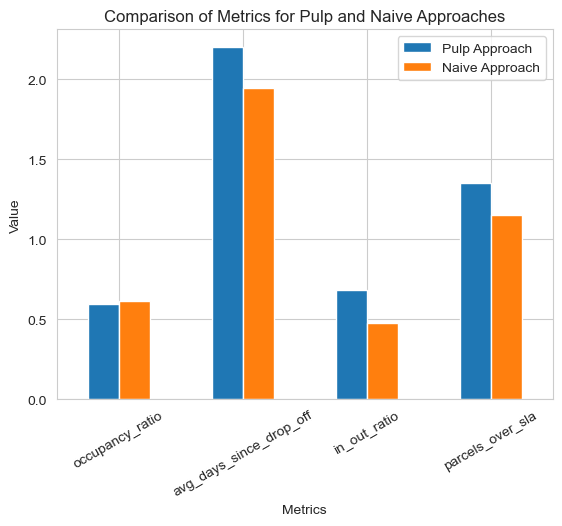

In [72]:
metrics_df.plot(kind='bar')
plt.title('Comparison of Metrics for Pulp and Naive Approaches')
plt.ylabel('Value')
plt.xlabel('Metrics')
plt.xticks(rotation=30)
plt.show()

#### Metrics Comparison

- **Occupancy Ratio** - Better approach: **Naive**. The Naive approach targets lockers with higher occupancy, aligning better with the goal of maximizing locker usage.
- **Average Days Since Drop-off** - Better Approach: **Pulp**. Targets lockers with higher average days since drop-off, which suggests it is more aligned with the goal of minimizing SLA violations.
- **In-Out Ratio** - Better Approach: **Pulp**. A higher in-out ratio is desirable as it indicates more parcels are moved from the warehouse to the locker, thus reducing the parcel count in the warehouse and maximizing locker usage. Pulp has a higher in-out ratio, making it better aligned with this objective.
- **Parcels Over SLA** - Better Approach: **Pulp**. It targets lockers with a higher number of parcels that are over the SLA time period.


The naive approach is better in terms of maximizing locker occupancy. 

The Pulp approach performs better on three out of four metrics: it aligns more with the goals of reducing SLA violations, reducing the warehouse load, and maximizing locker utilization. 

Depending on the business priorities, one might be more suitable than the other. If the most critical factor is to avoid SLA violations, the pulp approach might be more appropriate. If the focus is mainly on maximizing locker occupancy, the naive approach could be better.

### Comparing the chosen lockers

In [73]:
metrics_pulp = lockers_df[lockers_df['locker_id'].isin(prioritized_lockers_from_pulp)]
metrics_non_pulp = lockers_df[~lockers_df['locker_id'].isin(prioritized_lockers_from_pulp)]

avg_metrics_pulp = metrics_pulp[['occupancy_ratio', 'avg_days_since_drop_off', 'in_out_ratio', 'parcels_over_sla']].mean()
avg_metrics_non_pulp = metrics_non_pulp[['occupancy_ratio', 'avg_days_since_drop_off', 'in_out_ratio', 'parcels_over_sla']].mean()

metrics_df = pd.DataFrame({'Pulp Lockers': avg_metrics_pulp, 'Non-Pulp Lockers': avg_metrics_non_pulp})
metrics_df

,Pulp Lockers,Non-Pulp Lockers
occupancy_ratio,0.596333,0.602500
avg_days_since_drop_off,2.201206,1.800600
in_out_ratio,0.683889,0.510602
parcels_over_sla,1.350000,0.161111


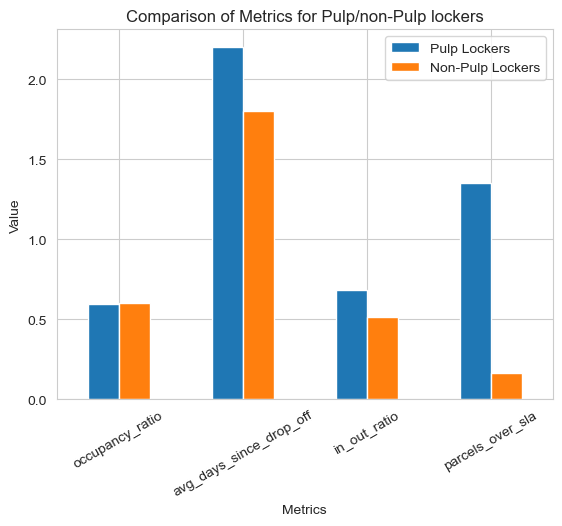

In [74]:
metrics_df.plot(kind='bar')
plt.title('Comparison of Metrics for Pulp/non-Pulp lockers')
plt.ylabel('Value')
plt.xlabel('Metrics')
plt.xticks(rotation=30)
plt.show()

,Pulp Lockers,Non-Pulp Lockers
occupancy_ratio,0.596333,0.602500
avg_days_since_drop_off,2.201206,1.800600
in_out_ratio,0.683889,0.510602
parcels_over_sla,1.350000,0.161111


#### Metrics Comparison

- Both approaches have high occupancy ratios, but the Non-Pulp Lockers have a slightly higher occupancy ratio. This aligns better with the goal of maximizing locker usage, although the difference is minimal.
- The Pulp is identifying lockers where parcels have been waiting longer. This is aligned with the business objective of avoiding SLA violations.
- The Pulp approach has a higher in-out ratio, making it better aligned with this objective.
- The Pulp is selecting lockers with more parcels that have violated the SLA. This might look like a disadvantage, but if the objective is to urgently clear out lockers that are close to or have violated SLA, then it makes sense.

In [98]:
from scipy.stats import mannwhitneyu, wilcoxon, ttest_ind

In [109]:
# Take a random sample of 20 non-Pulp lockers
random_sample_non_pulp = metrics_non_pulp.sample(n=20)

<Axes: ylabel='Density'>

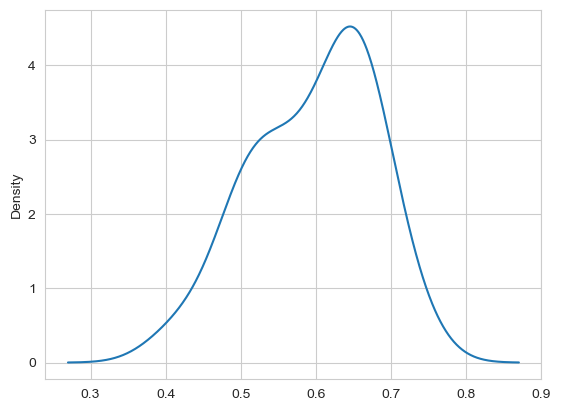

In [110]:
metrics_pulp.occupancy_ratio.plot(kind="kde")

<Axes: ylabel='Density'>

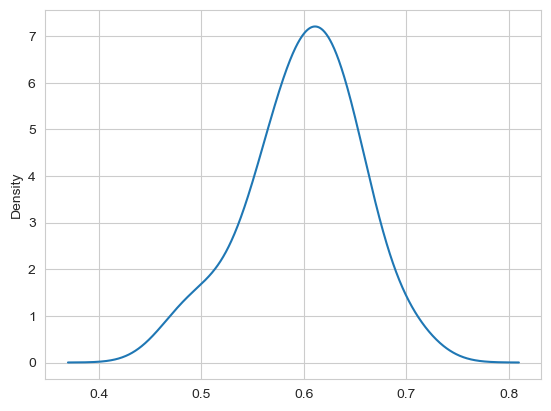

In [111]:
random_sample_non_pulp.occupancy_ratio.plot(kind="kde")

<Axes: ylabel='Density'>

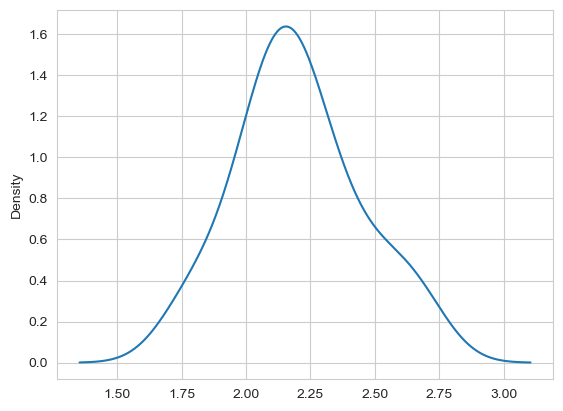

In [112]:
metrics_pulp.avg_days_since_drop_off.plot(kind="kde")

<Axes: ylabel='Density'>

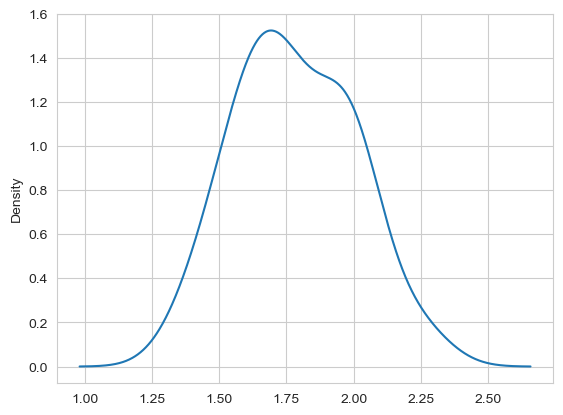

In [113]:
random_sample_non_pulp.avg_days_since_drop_off.plot(kind="kde")

In [96]:
# Function to run the Mann-Whitney U Test
def run_mannwhitneyu_test(metric):
    pulp_data = metrics_pulp[metric]
    non_pulp_data = random_sample_non_pulp[metric]
    
    # Perform Mann-Whitney U Test
    stat, p = mannwhitneyu(pulp_data, non_pulp_data)
    print(f"Mann-Whitney U Test for {metric}:")
    print(f"Statistics={stat}, p={p}")
    
    if p < 0.05:
        print(f"Significant difference between Pulp and random non-Pulp lockers for {metric}\n")
    else:
        print(f"No significant difference between Pulp and random non-Pulp lockers for {metric}\n")

# Run the test for each metric
for metric in ['occupancy_ratio', 'avg_days_since_drop_off', 'in_out_ratio', 'parcels_over_sla']:
    run_mannwhitneyu_test(metric)

Mann-Whitney U Test for occupancy_ratio:
Statistics=205.0, p=0.902834918212914
No significant difference between Pulp and random non-Pulp lockers for occupancy_ratio

Mann-Whitney U Test for avg_days_since_drop_off:
Statistics=364.5, p=8.962531006816031e-06
Significant difference between Pulp and random non-Pulp lockers for avg_days_since_drop_off

Mann-Whitney U Test for in_out_ratio:
Statistics=261.0, p=0.10110245372659285
No significant difference between Pulp and random non-Pulp lockers for in_out_ratio

Mann-Whitney U Test for parcels_over_sla:
Statistics=400.0, p=3.199671103214705e-09
Significant difference between Pulp and random non-Pulp lockers for parcels_over_sla



In [99]:
# Function to run the Mann-Whitney U Test
def run_t_test(metric):
    pulp_data = metrics_pulp[metric]
    non_pulp_data = random_sample_non_pulp[metric]
    
    # Perform Mann-Whitney U Test
    stat, p = ttest_ind(pulp_data, non_pulp_data)
    print(f"Two tailed t-test for {metric}:")
    print(f"Statistics={stat}, p={p}")
    
    if p < 0.05:
        print(f"Significant difference between Pulp and random non-Pulp lockers for {metric}\n")
    else:
        print(f"No significant difference between Pulp and random non-Pulp lockers for {metric}\n")

# Run the test for each metric
for metric in ['occupancy_ratio', 'avg_days_since_drop_off', 'in_out_ratio', 'parcels_over_sla']:
    run_t_test(metric)

Two tailed t-test for occupancy_ratio:
Statistics=0.20594727168713362, p=0.8379315152399545
No significant difference between Pulp and random non-Pulp lockers for occupancy_ratio

Two tailed t-test for avg_days_since_drop_off:
Statistics=5.602181760211695, p=2.000133708788193e-06
Significant difference between Pulp and random non-Pulp lockers for avg_days_since_drop_off

Two tailed t-test for in_out_ratio:
Statistics=1.8080828553049317, p=0.0785132848204218
No significant difference between Pulp and random non-Pulp lockers for in_out_ratio

Two tailed t-test for parcels_over_sla:
Statistics=10.282646761776899, p=1.5644690447412305e-12
Significant difference between Pulp and random non-Pulp lockers for parcels_over_sla



### Optimizing SLA Violation penalty


In [75]:
best_penalty = None
best_objective_value = float('-inf')

for penalty in range(1, 21):  # testing penalties from 1 to 20
    model = LpProblem(name="locker-optimization", sense=LpMaximize)

    locker_vars = LpVariable.dicts("Locker", lockers_df['locker_id'], 0, 1, 'Binary')

    model += lpSum(
    [
        locker_vars[i] * (
            a * lockers_df.loc[lockers_df['locker_id'] == i, 'occupancy_ratio'].values[0] +
            b * lockers_df.loc[lockers_df['locker_id'] == i, 'avg_days_since_drop_off'].values[0] +
            c * lockers_df.loc[lockers_df['locker_id'] == i, 'in_out_ratio'].values[0] + 
            penalty * lockers_df.loc[lockers_df['locker_id'] == i, 'parcels_over_sla'].values[0]
        )
        for i in lockers_df['locker_id']
    ]
), "Total_Priority"

    max_lockers_per_driver = 20
    model += lpSum([locker_vars[i] for i in lockers_df['locker_id']]) <= max_lockers_per_driver, "Max_Lockers_Per_Driver"
    
    # Solve the model
    model.solve()
    
    # Check the new objective function value
    new_objective_value = model.objective.value()
    if new_objective_value > best_objective_value:
        best_objective_value = new_objective_value
        best_penalty = penalty

print(f"The best penalty term for SLA violation is: {best_penalty}")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/lf/anaconda3/envs/snakes/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/cl/8l42ht8d4k70pf3by032y2qc0000gn/T/7a43f2ff707c4e60912371d821cbd34c-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/cl/8l42ht8d4k70pf3by032y2qc0000gn/T/7a43f2ff707c4e60912371d821cbd34c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 6 COLUMNS
At line 807 RHS
At line 809 BOUNDS
At line 1010 ENDATA
Problem MODEL has 1 rows, 200 columns and 200 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 96.6286 - 0.00 seconds
Cgl0004I processed model has 1 rows, 200 columns (200 integer (200 of which binary)) and 200 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -96.6286
Cbc0038I Before mini branch and bound, 200 integers at b

*Of course!!*

## Section III: Recommendation & Next Steps

### Recommendations

- Optimize driver routes based on the prioritized lockers to save on time and fuel.
- Increase the frequency of pickups from high-priority lockers.


### Risks and Limitations

- Assumes the snapshot data is representative.
- Proximity to warehouse does not account for road conditions, traffic, etc.


### Future Iterations
- Dynamic Updates: Move to a real-time system instead of daily snapshots.
    - Using a model to predict `days_since_seller_drop_off`.
- Feedback Loop: Include performance metrics to adapt the framework based on its past success or failures.